## **Disaster Tweet Classification**




---


## Project Overview
**Task**: Binary classification of tweets as "disaster" (1) or "non-disaster" (0)

**Dataset**:
- Over 7,000 labeled tweets from Kaggle
- Columns we use: `text` (tweet content), `target` (0/1 label)

**Approach**:
1. Compare simple models (Logistic Regression, Naive Bayes)
2. Implement advanced BERT model
3. Evaluate performance using precision/recall/F1


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [2]:
# Download NLTK dataset

nltk.download("wordnet")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load and check data

file_id = "1zzzUfCATIywtQWi0NE0X6yOe7ZgnIJzS"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

data = pd.read_csv(url)

# Display data and some statistics
display(data)
display(data.info())
display(data["target"].value_counts())
display(f"Number of duplicates: {data['text'].duplicated().sum()}")

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


None

,count
target,
0,4342
1,3271


'Number of duplicates: 110'

In [4]:
# Check for duplicates

duplicates = data[data.duplicated(subset='text', keep=False)]
duplicates["text"].value_counts().head()

,count
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5


In [5]:
# Drop duplicated rows

data = data.drop_duplicates(subset ="text", keep = "first").reset_index(drop=True)
data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7498,#WorldNews Fallen powerlines on G:link tram: U...,1
7499,on the flip side I'm at Walmart and there is a...,1
7500,Suicide bomber kills 15 in Saudi security site...,1
7501,Two giant cranes holding a bridge collapse int...,1


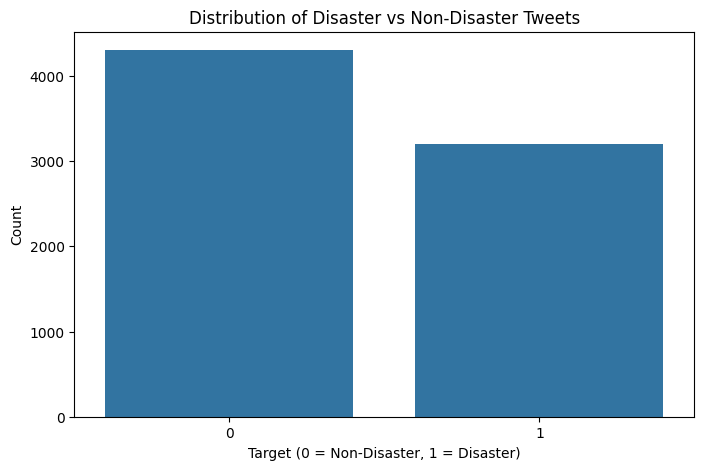


Target value counts:
target
0    4305
1    3198
Name: count, dtype: int64


In [6]:
# Plot target after deleting duplicates

plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

# Print exact counts
print("\nTarget value counts:")
print(data['target'].value_counts())

 Observation:

 After removing duplicate entries from the dataset, a class imbalance remains:

    57.4% of tweets are labeled as non-disaster

    42.6% are labeled as disaster

This imbalance may affect model performance, particularly for detecting disaster-related tweets. It suggests the need of evaluation with metrics like F1-score, which is more suitable for imbalanced datasets.


## **Text Preprocessing Pipeline**

This pipeline transforms raw tweets into clean text for modeling:

1. Normalization
   - Add space between lowercase and uppercase  
   - Convert to lowercase  
   - Remove URLs (`https://...`), mentions (`@user`)

2. Special Character Handling
   - Remove hashtag symbols (`#`) but keep the word  
   - Strip all punctuation and numbers
   - Reduce exaggerations (("soooo" → "so", "heyyyyy" → "hey"))

3. Token Processing
   - Tokenize text into words  
   - Remove standard English stopwords ("the", "and")   

4. Lemmatization
   - Convert words to base forms ("running" → "run")

In [7]:
# Function for cleaning text

def preprocess_text(text_series):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    cleaned_texts = []

    for sentence in text_series:
        sentence = re.sub(r"([a-z])([A-Z])", r"\1 \2", sentence)
        sentence = sentence.lower()
        sentence = re.sub(r"http\S+|www\S+|https\S+", "", sentence)
        sentence = re.sub(r"@\w+", "", sentence )
        sentence = re.sub(r"#", "", sentence )
        sentence = re.sub(r"[^a-z\s]", "", sentence)
        sentence = re.sub(r'(.)\1{2,}', r'\1', sentence)


        tokens = word_tokenize(sentence)
        tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

        cleaned_sentence = " ".join(tokens)
        cleaned_texts.append(cleaned_sentence)

    return cleaned_texts


In [8]:
# Call a function and check cleaned text

preprocessed_data = preprocess_text(data["text"])
display(preprocessed_data)

['deed reason earthquake may allah forgive',
 'forest fire near ronge sask canada',
 'resident asked shelter place notified officer evacuation shelter place order expected',
 'people receive wildfire evacuation order california',
 'got sent photo ruby alaska smoke wildfire pours school',
 'rocky fire update california hwy closed direction due lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street manitou colorado spring area',
 'top hill see fire wood',
 'there emergency evacuation happening building across street',
 'afraid tornado coming area',
 'three people died heat wave far',
 'haha south tampa getting flooded hah wait second live south tampa gon gon fvck flooding',
 'raining flooding florida tampa bay tampa day ive lost count',
 'flood bago myanmar arrived bago',
 'damage school bus multi car crash breaking',
 'whats man',
 'love fruit',
 'summer lovely',
 'car fast',
 'goal',
 'ridiculous',
 'london cool',
 'love skiing',
 'wonderful day',
 '

In [9]:
# Add cleaned text to original data frame

data['clean_text'] = preprocessed_data
display(data)

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...
7498,#WorldNews Fallen powerlines on G:link tram: U...,1,world news fallen powerlines glink tram update...
7499,on the flip side I'm at Walmart and there is a...,1,flip side walmart bomb everyone evacuate stay ...
7500,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kill saudi security site mosque...
7501,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse nearby...


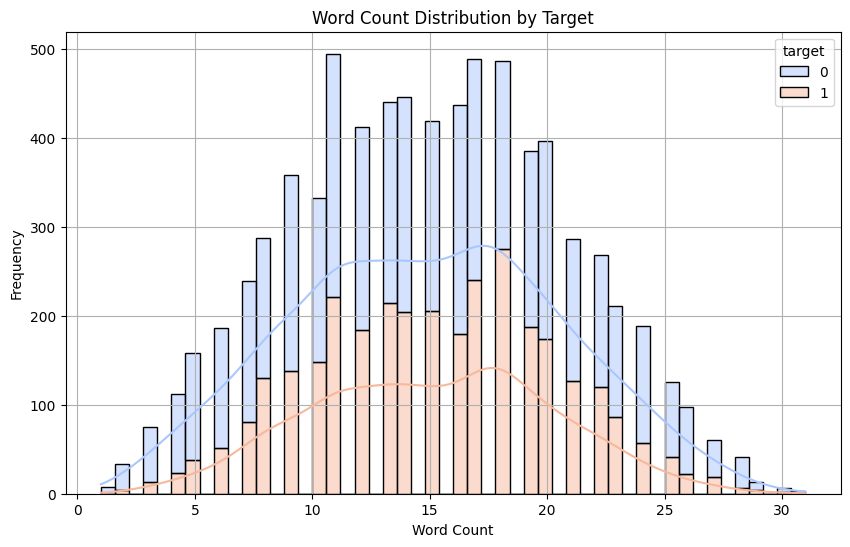

In [10]:
# Calculate word count for each message

data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Create a histogram plot

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='word_count', hue='target', kde=True, bins=50, palette='coolwarm', multiple="stack")
plt.title('Word Count Distribution by Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

 Observation:

    📉 Disaster tweets: tend to be shorter

    📈 Non-disaster tweets: tend to be longer

     Overall word count distribution is approximately normal

In [11]:
# Classification report function

def report(y_test, y_pred, model):
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=["not disaster", "disaster"]))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not disaster", "disaster"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.grid(False)
    plt.show()


## Model 1: Logistic Regression

Classification Report:

              precision    recall  f1-score   support

not disaster       0.81      0.91      0.86       861
    disaster       0.85      0.71      0.77       640

    accuracy                           0.82      1501
   macro avg       0.83      0.81      0.82      1501
weighted avg       0.83      0.82      0.82      1501



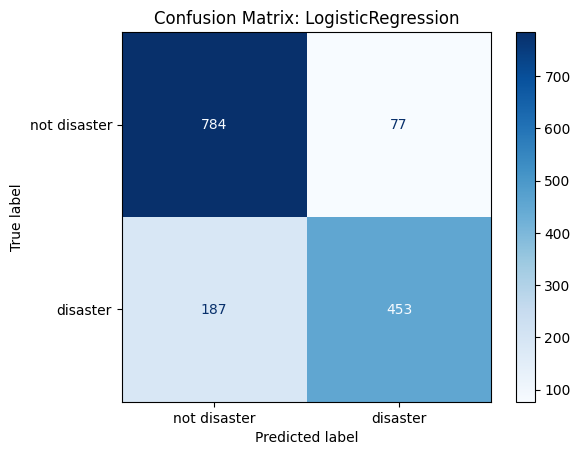

In [ ]:
# Split data into feature and target
X = data["clean_text"]
y = data["target"]


# Split data for train and test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)


# Vectorize text
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Define the model
model = LogisticRegression(random_state=42)

# Fit it on train data
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Print classification report
report(y_test, y_pred,model)

Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report:

              precision    recall  f1-score   support

not disaster       0.81      0.91      0.85       861
    disaster       0.85      0.71      0.77       640

    accuracy                           0.82      1501
   macro avg       0.83      0.81      0.81      1501
weighted avg       0.82      0.82      0.82      1501



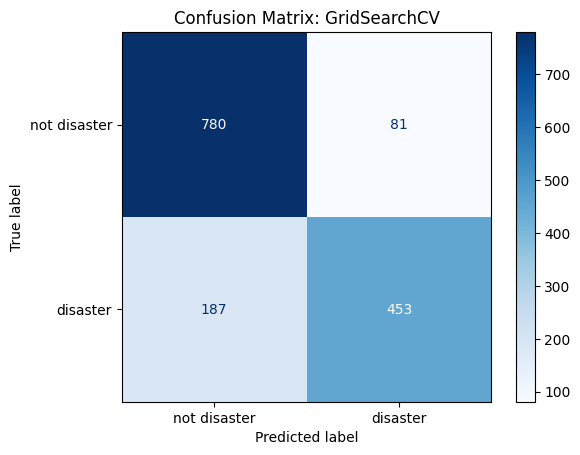

In [ ]:
# Logistic Regression Grid search for best parameters
params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(LogisticRegression(), params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

#Print best parameters
print("Best Params:", grid.best_params_)

# Print classification report
report(y_test, y_pred)

Grid search did not improve performance compared to the model without tuned hyperparameters

## Model 2: Random Forest



Classification Report:

              precision    recall  f1-score   support

not disaster       0.78      0.86      0.82       861
    disaster       0.78      0.68      0.73       640

    accuracy                           0.78      1501
   macro avg       0.78      0.77      0.77      1501
weighted avg       0.78      0.78      0.78      1501



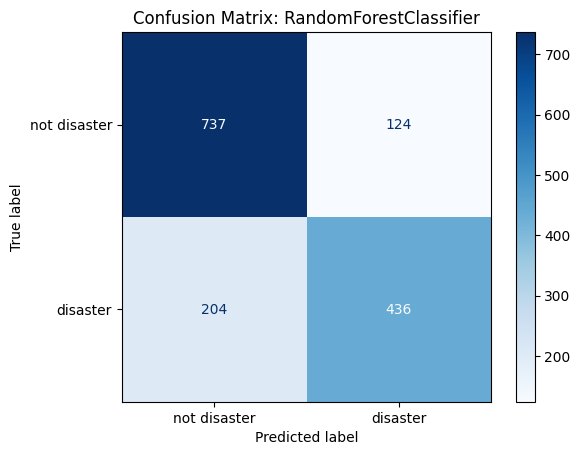

In [ ]:
# Vectorize text
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Random Forest model
model = RandomForestClassifier(random_state = 3)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Print metrics
report(y_test, y_pred, model)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 7, 'n_estimators': 100}
Classification Report:

              precision    recall  f1-score   support

not disaster       0.80      0.85      0.82       861
    disaster       0.78      0.71      0.74       640

    accuracy                           0.79      1501
   macro avg       0.79      0.78      0.78      1501
weighted avg       0.79      0.79      0.79      1501



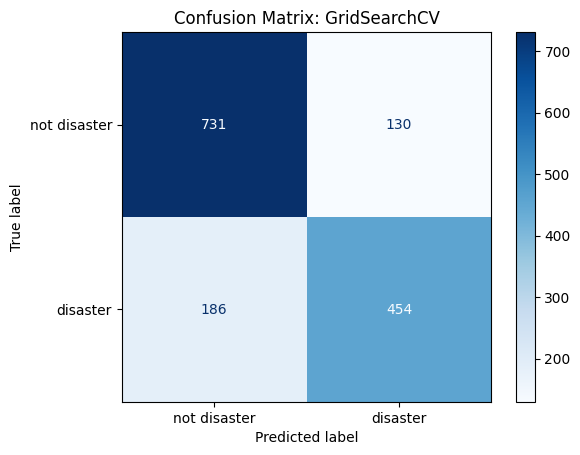

In [ ]:
# Grid search for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10,7],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

#Print best parameters
print("Best Parameters:", grid_search.best_params_)

#Print report
report(y_test, y_pred, grid_search)

Grid search did improve performance compared to the model without tuned hyperparameters by 1 %.
But still Random Forest did not outperform Logistic Regression

## Model 3: Pretrained transformer

In [ ]:
# Imports and installation
!pip install transformers datasets

from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
import os

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.681100
20,0.649900
30,0.596200
40,0.526600
50,0.460400
60,0.541200
70,0.452300
80,0.459800
90,0.537700
100,0.474600


{'eval_loss': 0.5110139846801758, 'eval_runtime': 8.8717, 'eval_samples_per_second': 169.19, 'eval_steps_per_second': 2.705, 'epoch': 4.0}
Classification Report:

              precision    recall  f1-score   support

not disaster       0.84      0.86      0.85       874
    disaster       0.80      0.77      0.78       627

    accuracy                           0.82      1501
   macro avg       0.82      0.81      0.81      1501
weighted avg       0.82      0.82      0.82      1501



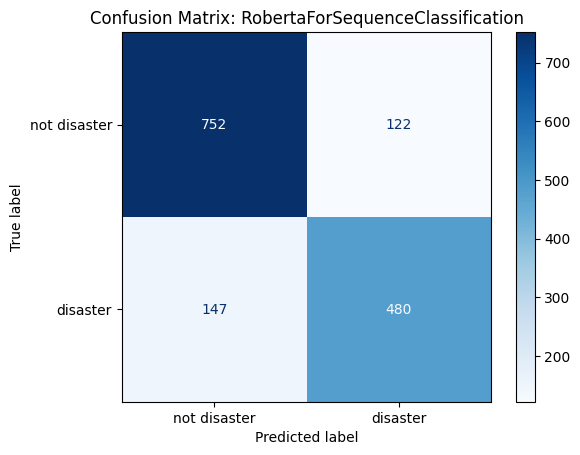

In [ ]:
# 1. Prepare the data
train_texts, val_texts, train_labels, val_labels = train_test_split(data["clean_text"].tolist(), data["target"].tolist(), test_size=0.2, random_state=42)

# 2. Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=128)

# 3. Dataset wrapper
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# 4. Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
os.environ["WANDB_DISABLED"] = "true"

# 5. Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()
results = trainer.evaluate()

#Print results
print(results)

# Get predictions
preds_output = trainer.predict(val_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

#Print report
report(y_true, y_pred, model)

In [ ]:
from torch.utils.data import Dataset

# Your message
text = "No way, it was not true, that  huricane happend today in florida"

# Tokenize
encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

# Wrap in a Dataset so Trainer can handle it
class SingleInputDataset(Dataset):
    def __init__(self, encoding):
        self.encoding = encoding

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return {key: val.squeeze(0) for key, val in self.encoding.items()}

single_dataset = SingleInputDataset(encoding)

# Predict
preds = trainer.predict(single_dataset)
pred_label = np.argmax(preds.predictions, axis=1)[0]

# Interpret prediction
if pred_label == 1:
    print("🔥 Predicted: Disaster")
else:
    print("✅ Predicted: Not a disaster")


🔥 Predicted: Disaster


##  **Project Summary**

---



In this project, I worked on a binary classification task using a dataset of tweets labeled as either disaster-related or not disaster-related. The goal was to build and evaluate models that can automatically detect disaster-related content from raw text.

 Data Preparation

    Loaded a labeled dataset of tweets.

    Performed initial data cleaning: removed duplicates and preprocessed tweet text.
##  Models and Results
### 1. Logistic Regression

This was the first baseline model.

    Accuracy: 82%

    Class-wise Performance:

        Not disaster: F1 = 0.86

        Disaster: F1 = 0.77

Applied Grid Search for hyperparameter tuning, resulting in similar performance.
### 2. Random Forest

Random Forest results:

    Accuracy: 78%

    Slightly lower performance overall compared to logistic regression.

    Grid Search improved results slightly (Accuracy = 79%), but still behind logistic regression.

### 3. RoBERTa (Pre-trained Transformer)

Used the roberta-base transformer fine-tuned on the dataset.

    Accuracy: 82%

    F1 Scores:

        Not disaster: 0.85

        Disaster: 0.78

Although similar in overall accuracy to logistic regression, RoBERTa showed more balanced performance between the two classes and leveraged contextual understanding better.

## Conclusion

    Logistic Regression performed surprisingly well for a simple linear model.

    Random Forest did not significantly outperform logistic regression and showed weaker generalization.

    RoBERTa offered strong performance with the potential for further gains through additional fine-tuning or larger transformer models.